In [3]:
# =========================================
# Cell 1 : imports & helpers
# =========================================
import numpy as np
import torch, math
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)

DEVICE = "cpu"   # everything is light enough for CPU

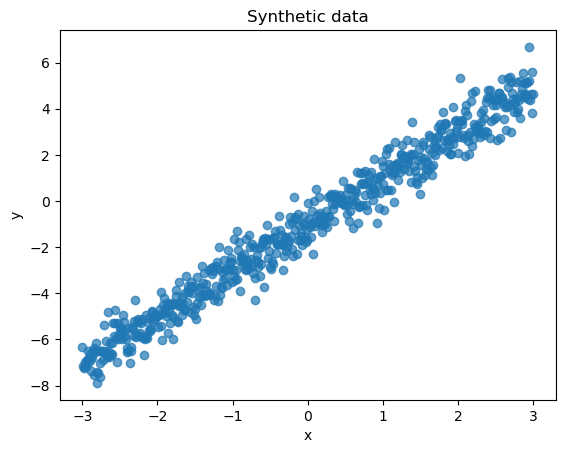

In [17]:
# =========================================
# Cell 2 : synthetic data   y = 2x -1 + noise
# =========================================
N = 600
true_w, true_b = 2.0, -1.0
x_data = torch.linspace(-3, 3, N)
noise  = 0.6 * torch.randn(N)
y_data = true_w * x_data + true_b + noise

plt.scatter(x_data, y_data, alpha=0.7)
plt.title("Synthetic data"); plt.xlabel("x"); plt.ylabel("y")
plt.show()

In [18]:
# =========================================
# Cell 3 : log posterior function log p(w,b | D)  (up to constant)
# =========================================
def log_posterior(params, x, y, sigma_obs=0.6, tau_prior=5.0):
    """
    params: tensor([w, b])
    Returns log likelihood + log prior
    """
    w, b = params
    # log likelihood  ∑ -0.5/σ² * (y - (wx+b))²
    ll = -0.5 / sigma_obs**2 * torch.sum((y - (w * x + b))**2)
    # log prior  N(0, τ²)
    lp = -0.5 / tau_prior**2 * (w**2 + b**2)
    return ll + lp

In [22]:
# =========================================
# Cell 4 : simple MH sampler
# =========================================
def metropolis_hastings(
        init_params,       # tensor([w0, b0])
        step_size=0.05,    # proposal std
        n_samples=10_000, burn_in=1000):
    
    samples = []
    params = init_params.clone()
    current_lp = log_posterior(params, x_data, y_data)
    
    for i in range(n_samples + burn_in):
        proposal = params + step_size * torch.randn_like(params)
        proposal_lp = log_posterior(proposal, x_data, y_data)
        
        accept_ratio = torch.exp(proposal_lp - current_lp)
        if torch.rand(1) < accept_ratio:
            params, current_lp = proposal, proposal_lp  # accept
        if i >= burn_in:
            samples.append(params.clone())
            
    return torch.stack(samples)      # [n_samples, 2]

Posterior mean w: 2.005122184753418
Posterior mean b: -1.0166898965835571


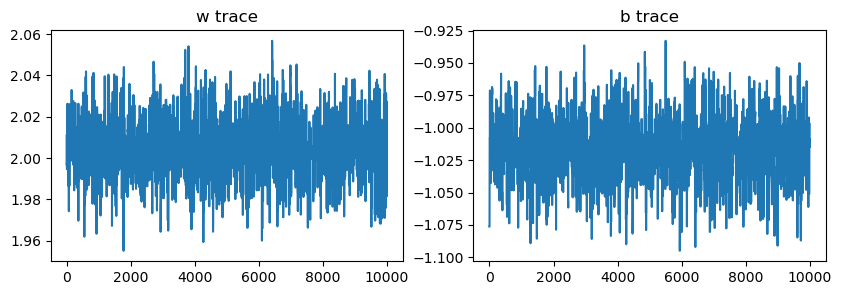

In [23]:
# =========================================
# Cell 5 : run MCMC
# =========================================
init = torch.tensor([0.0, 0.0])      # start at origin
posterior_samples = metropolis_hastings(init)

w_chain = posterior_samples[:,0]
b_chain = posterior_samples[:,1]

print("Posterior mean w:", w_chain.mean().item())
print("Posterior mean b:", b_chain.mean().item())

# Trace plots
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].plot(w_chain); ax[0].set_title("w trace")
ax[1].plot(b_chain); ax[1].set_title("b trace")
plt.show()

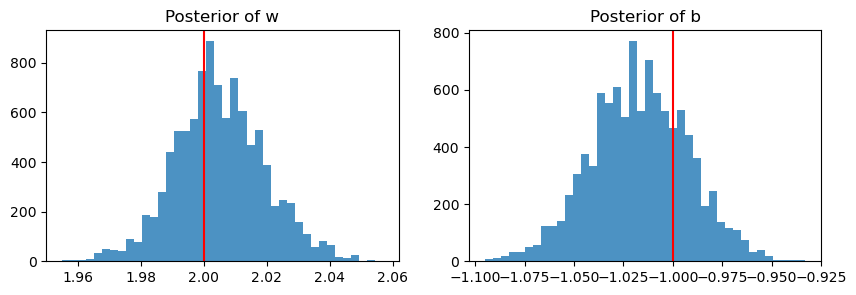

In [24]:
# =========================================
# Cell 6 : histogram of w and b
# =========================================
fig, ax = plt.subplots(1,2, figsize=(10,3))
ax[0].hist(w_chain.numpy(), bins=40, alpha=0.8); ax[0].axvline(true_w, color='r')
ax[0].set_title("Posterior of w")
ax[1].hist(b_chain.numpy(), bins=40, alpha=0.8); ax[1].axvline(true_b, color='r')
ax[1].set_title("Posterior of b")
plt.show()

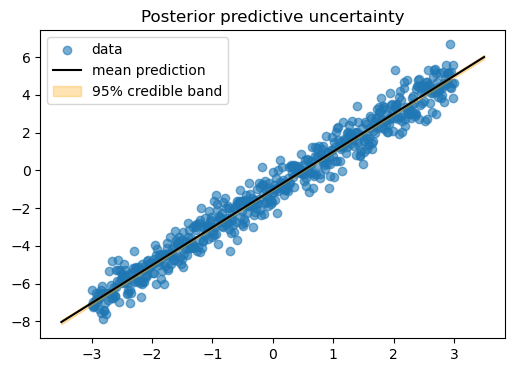

In [25]:
# =========================================
# Cell 7 : posterior predictive mean & 95% credible band
# =========================================
x_plot = torch.linspace(-3.5, 3.5, 200)
# Collect predictions from 1000 posterior weight samples
idx = torch.randint(len(posterior_samples), (1000,))
pred_mats = []
for i in idx:
    w, b = posterior_samples[i]
    pred_mats.append(w * x_plot + b)
pred_mats = torch.stack(pred_mats)          # [1000, 200]

mean_pred = pred_mats.mean(0)
conf_low  = torch.quantile(pred_mats, 0.025, dim=0)
conf_high = torch.quantile(pred_mats, 0.975, dim=0)

plt.figure(figsize=(6,4))
plt.scatter(x_data, y_data, alpha=0.6, label="data")
plt.plot(x_plot, mean_pred, color='black', label="mean prediction")
plt.fill_between(x_plot, conf_low, conf_high, color='orange', alpha=0.3,
                 label="95% credible band")
plt.legend(); plt.title("Posterior predictive uncertainty"); plt.show()

In [26]:
# =========================================
# Cell 8 : test on unseen x
# =========================================
# create 10 new points
x_new = torch.linspace(-4, 4, 10)
with torch.no_grad():
    preds = []
    for p in posterior_samples[::10]:       # ~400 samples
        w, b = p
        preds.append(w * x_new + b)
    preds = torch.stack(preds)
mean_new = preds.mean(0)
std_new  = preds.std(0)

for xi, mu, sd in zip(x_new, mean_new, std_new):
    print(f"x={xi:+.2f}   ŷ={mu:+.2f}  ± {1.96*sd:.2f} (95% CI)   true y={true_w*xi + true_b:.2f}")

x=-4.00   ŷ=-9.04  ± 0.12 (95% CI)   true y=-9.00
x=-3.11   ŷ=-7.25  ± 0.10 (95% CI)   true y=-7.22
x=-2.22   ŷ=-5.47  ± 0.08 (95% CI)   true y=-5.44
x=-1.33   ŷ=-3.69  ± 0.06 (95% CI)   true y=-3.67
x=-0.44   ŷ=-1.91  ± 0.05 (95% CI)   true y=-1.89
x=+0.44   ŷ=-0.13  ± 0.05 (95% CI)   true y=-0.11
x=+1.33   ŷ=+1.66  ± 0.06 (95% CI)   true y=1.67
x=+2.22   ŷ=+3.44  ± 0.08 (95% CI)   true y=3.44
x=+3.11   ŷ=+5.22  ± 0.10 (95% CI)   true y=5.22
x=+4.00   ŷ=+7.00  ± 0.12 (95% CI)   true y=7.00
